In [1]:
import pickle
import re
import pandas as pd
from wordcloud import WordCloud, STOPWORDS
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

In [2]:
pd.set_option('display.max_colwidth', 800)

In [3]:
scrape_path_0="../data/scrapes_atheism.pickle"
scrape_path_1="../data/scrapes_christianity.pickle"

try:
    with open(scrape_path_0,'rb') as handle:
        scrape0=pickle.load(handle)
    with open(scrape_path_1,'rb') as handle:
        scrape1=pickle.load(handle)
except FileNotFoundError as e:
    e.strerror = "Pls run 01_scrape_reddit first to pull the data."
    raise e

df0=pd.DataFrame(scrape0,columns=["post"])
df0['label']=0

df1=pd.DataFrame(scrape1,columns=["post"])
df1['label']=1

df=pd.concat([df0,df1])
df.reset_index(inplace=True,drop=True)

### EDA

Let's take a look at the combined DF.

In [4]:
df

,post,label
0,"This is the nail in the coffin for the idea of the Christian God, imo. I 100% believed the Bible, believed in God, Jesus, the Holy Ghost, miracles, Angels, Devils, Demons, Heaven, Hell and the soul. I was indoctrinated from BIRTH to believe it and by golly it worked. I wanted to become a preacher, I wanted to tell people about Jesus because I truly believed they were going to hell! So how, after 30 years of head-in-the-sand belief, would God suddenly not be real to me? I honestly got ""saved"", baptized, and believed in literally everything. And now? Nothing. I believe there is no ""supreme being"". With literally everything in my life geared toward believing in God and being surrounded by what is said by Christians to be God's creation, it should be *impossible* for me to not believe. I s...",0
1,"I’m closeted, always been, and always will be. \n\nI still get stupid stuff and arguments spewed at me by theists around about their scripture not saying what it clearly says, but when I break their confidence with a rebuttal, I can’t fully deliver the point while still pretending that I fully agree with their religion. It’s just going to sound like an offense, which Is a threat to my cover. \n\nJust hear to rant and probably see if someone has a similar experience.",0
2,"The FIFA world cup in Qatar should be a reminder to everyone that the Middle East is still in the stone age in a lot of aspects. Up to 6000 slaves died building the stadiums for the world cup. Women are treated as pets, and are required ""permission"" from their male guardians to get married, study abroad, work certain jobs, even travel out of the country if they're under the age of 25. A woman who gets raped would be arrested for the crime of adultery. Gay sex is also punishable by jail. Qatar is ruled by an emir who outlawed political parties and elections. And these backwards laws and standards are somewhat moderate compared to other Middle Eastern countries like Saudi Arabia. I saw an article about a British soccer fan who's been going to every world cup for the past 32 years, but is...",0
3,"We moved from the DC metro area last year to the backwoods of KY. Background: I’m from here, most of my good family is here, and we can actually afford to own a home for the first time and be comfortable. So this wasn’t a random move. \n\nAnyway, my 10 year old son, who has loved every minute of being here, asked to join the cub scouts. After much ado tracking these people down and dates being moved we finally attended his first meeting last night. Now we knew there was a bit of religion in the scouts, and I had told him that. He was so excited to join he didn’t seem to mind. Well, I might as well have taken him to the local baptist church. It was little more than an hour sermon, prayer, praise god, you are a representative of your almighty creator, etc. \n\nWe left at the end and he l...",0
4,"They spend so much time focusing on arbitrary rules (Ex: not eating pork, not drinking alcohol, going to church, not wearing revealing clothing, not listening to secular music, not drinking coffee, not celebrating certain holidays, no premarital sex, no divorce, no fun, e.g), that they simply don’t have time to build their humanly character. For example, parents are hyper focused on following the rules of the church that they simply can’t look into the mirror and see how undeniably flawed they are. My mom is whiny, mean, cold, and unfriendly but that doesn’t matter as long as she’s being a good obedient Christian. My dad is extremely zealous and stops trying to spend time with his kids. They just don’t care and don’t see the harm they cause others. This is why church is a feeding groun...",0
...,...,...
10078,"If Jesus died for our sins, what's keeping us from sinning? I mean, if it is, yk, covered why shouldn't we all party like it's the 1920s",1
10079,Hello everybody it may seem like a dumb question but when i pray do i keep my eyes close or open ?\nThanks for answe

#### And the split of 1/0 labels?

In [5]:
df['label'].value_counts(normalize=True)

1    0.501339
0    0.498661
Name: label, dtype: float64

Quite an equal representation (50%) of labels are 1 and 0.  
No need to do any balancing here.

### Clean the dataset

Let's make all lower case

In [6]:
df['post']=df['post'].str.lower()

Let's remove the newlines

In [7]:
df['post'] = df['post'].replace(r'\n',' ', regex=True) 

Let's remove any URL in the posts.

In [8]:
df['post'] = df['post'].str.replace('http\S+|www.\S+', '', case=False, regex=True)

Double check...

In [9]:
df['post']

0        this is the nail in the coffin for the idea of the christian god, imo. i 100% believed the bible, believed in god, jesus, the holy ghost, miracles, angels, devils, demons, heaven, hell and the soul. i was indoctrinated from birth to believe it and by golly it worked. i wanted to become a preacher, i wanted to tell people about jesus because i truly believed they were going to hell! so how, after 30 years of head-in-the-sand belief, would god suddenly not be real to me? i honestly got "saved", baptized, and believed in literally everything. and now? nothing. i believe there is no "supreme being". with literally everything in my life geared toward believing in god and being surrounded by what is said by christians to be god's creation, it should be *impossible* for me to not believe. i s...
1                                                                                                                                                                                              

Looks fine. Let's test...

In [10]:
df[df['post'].str.contains("http")]

,post,label


Great. No URL found.  


Let's lemmatize the dataset now.

In [11]:
lemmatizer=WordNetLemmatizer()

In [12]:
df['post']=df['post'].apply(lambda x: ' '.join([lemmatizer.lemmatize(w) for w in x.split()]))

Let's persist this df to file now.

In [13]:
df.to_pickle('../data/combined.pickle')

#### Let's also look at how many words each post contains.

In [14]:
df['len']=df['post'].apply(lambda x: len(re.split(r'\s',x)))
df_0=df[df['label']==0]
df_1=df[df['label']==1]

In [15]:
df_1['len'].describe()
pd.DataFrame([df_0['len'].describe().rename("Label 0"),df_1['len'].describe().rename("Label 1")])

,count,mean,std,min,25%,50%,75%,max
Label 0,5028.0,173.581146,236.776637,20.0,62.0,115.0,204.0,7799.0
Label 1,5055.0,183.982789,272.302952,20.0,54.0,105.0,204.0,4996.0


No real difference between the lengths of post between the 2 categories.

Let's look at the hot words between the 2 labels

In [16]:
text_0 = " ".join(sent.split()[1] for sent in df_0['post'])
text_1 = " ".join(sent.split()[1] for sent in df_1['post'])

title_0="Atheism"
title_1="Christianity"

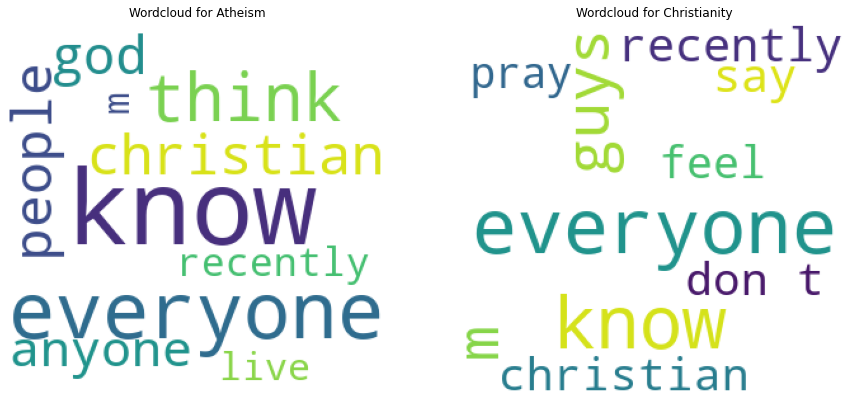

In [17]:
wordcloud1 = WordCloud(width = 300, height = 300,
                background_color ='white',
                min_font_size = 10,max_words=10).generate(text_0)

wordcloud2 = WordCloud(width = 300, height = 300,
                background_color ='white',
                min_font_size = 10,max_words=10).generate(text_1)
 
# plot the WordCloud image     

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,15))

ax1.imshow(wordcloud1)
ax1.axis("off")
ax1.title.set_text(f'Wordcloud for {title_0}')
ax2.imshow(wordcloud2)
ax2.axis("off")
ax2.title.set_text(f'Wordcloud for {title_1}')
 
plt.show()

By visual observation, several words appear in both catergories.  
'Everyone','Christian','know','recently'

Let's try again with stopwords removed

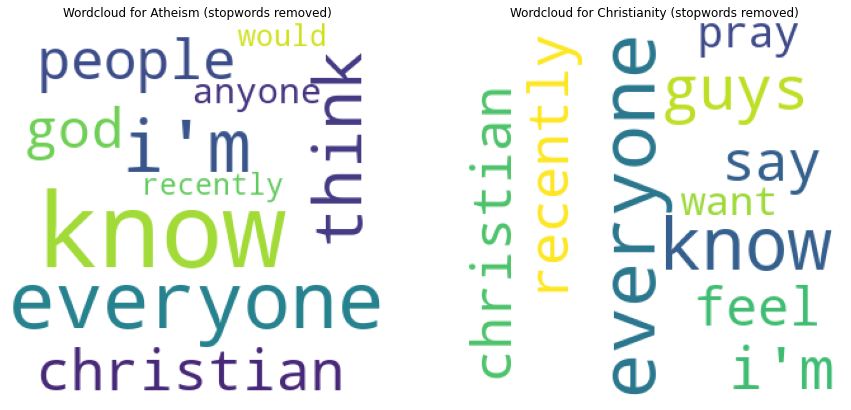

In [18]:
wordcloud1 = WordCloud(width = 300, height = 300,
                background_color ='white',stopwords=stopwords.words('english'),
                min_font_size = 10,max_words=10).generate(text_0)

wordcloud2 = WordCloud(width = 300, height = 300,
                background_color ='white',stopwords=stopwords.words('english'),
                min_font_size = 10,max_words=10).generate(text_1)
 
# plot the WordCloud image     

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,15))

ax1.imshow(wordcloud1)
ax1.axis("off")
ax1.title.set_text(f'Wordcloud for {title_0} (stopwords removed)')
ax2.imshow(wordcloud2)
ax2.axis("off")
ax2.title.set_text(f'Wordcloud for {title_1} (stopwords removed)')
 
plt.show()

By visual observation, the same several words appear in both catergories.  
'Everyone','Christian','recently','know'

In [19]:
cvec = CountVectorizer(stop_words='english')
cfm = cvec.fit_transform(df['post'])
cvec_weights = [(word, cfm.getcol(idx).sum()) for word, idx in cvec.vocabulary_.items()]
df_weights=pd.DataFrame(cvec_weights,columns=["features","freq"])
df_weights.sort_values(by="freq",inplace=True,ascending=False)
d20=df_weights.head(20)

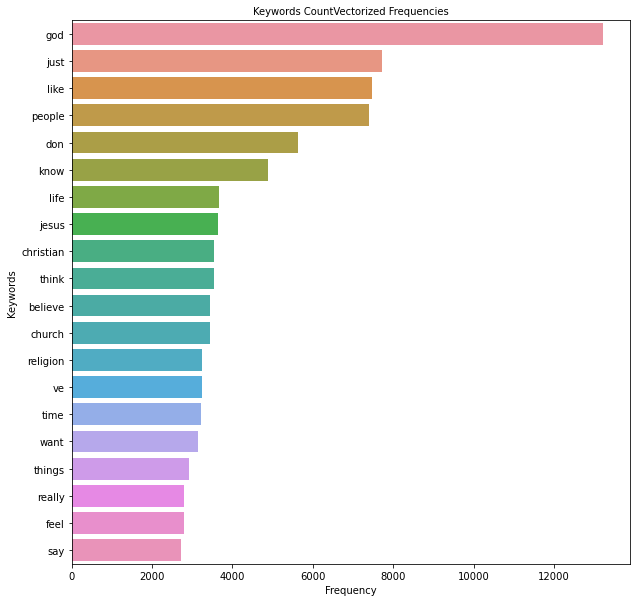

In [20]:
plt.figure(figsize=(10,10))
sns.barplot(x=d20['freq'], y=d20['features'])
plt.title("Keywords CountVectorized Frequencies", fontsize=10)
plt.ylabel('Keywords', fontsize=10)
plt.yticks(fontsize=10)
plt.xlabel('Frequency', fontsize=10)
_=plt.xticks(fontsize=10)

### A TF-IDF-ed wordcloud

We'll be using TF-IDF later, but for now let's look at its impact on the wordcloud.

In [21]:
tvec = TfidfVectorizer(stop_words='english',max_df=0.8)
tfm = tvec.fit_transform(df['post'])
tfidf_weights = [(word, tfm.getcol(idx).sum()) for word, idx in tvec.vocabulary_.items()]
df_weights=pd.DataFrame(tfidf_weights,columns=["features","freq"])
df_weights.sort_values(by="freq",inplace=True,ascending=False)
d20=df_weights.head(20)

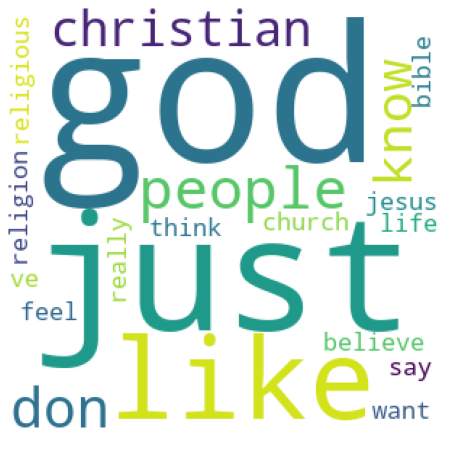

In [22]:
w = WordCloud(width=300, height=300, mode='RGBA', background_color='white', max_words=20).fit_words(dict(tfidf_weights))
plt.figure(figsize=(8,8))
plt.imshow(w)
_=plt.axis('off')

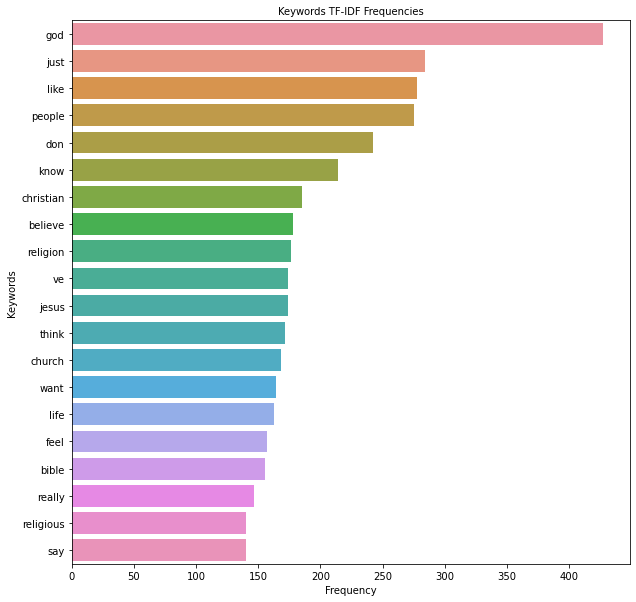

In [23]:
plt.figure(figsize=(10,10))
sns.barplot(x=d20['freq'], y=d20['features'])
plt.title("Keywords TF-IDF Frequencies", fontsize=10)
plt.ylabel('Keywords', fontsize=10)
plt.yticks(fontsize=10)
plt.xlabel('Frequency', fontsize=10)
_=plt.xticks(fontsize=10)

Let's move on to pump the entire dataframe into a preliminary model next.